In diesem Notebook verwenden wir die originalen Spektrogramme um mit FFNN und CNN die einzelnen Fledermausarten zu erkennen.

In [4]:
# Die Daten befinden sich in der Datenbank. read_data stellt eine Funktion read_data bereit, die die Anzahl der Spektrogramme pro Klasse erhält
# und die Daten aus der Datenbank einliest, sklaliert, die STFT durchführt und das Ganze in einen pandas.DataFrame data schreibt. Wichtig sind
# hierbei die Spalten data['arr'], die tatsächlichen Daten und data['target'], die Klassenzugehörigkeit.
# read_data ist je nach NN mit unterschiedlich vielen Bildern pro Klasse aufzurufen, da die Modele unterschiedlich viel RAM benötigen

from read_data import read_data
data = read_data(200)

/home/lo/pg/ML/ML-Projekt/read_data.py:30: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [6]:
# Die Daten und Targets werden in numpy.Arrays mit den richtigen Shapes geschrieben und gleich in Trainings- und Testdaten gesplittet

X = np.concatenate(data['arr'].values).reshape(-1, 256, 128)
print(X.shape)

y = to_categorical(np.array(data['target']))
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(5700, 256, 128)
(5700, 19)


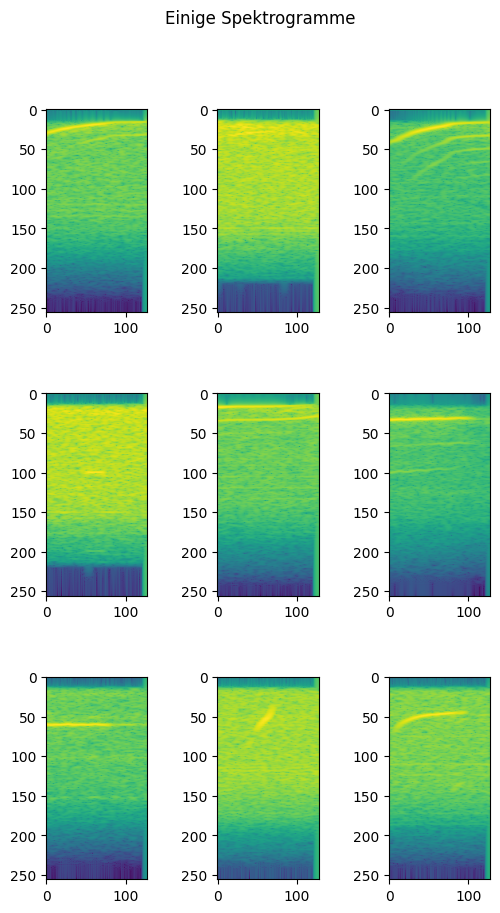

In [23]:
# Ausgabe von neun zufälligen Spektrogrammen um einen Überblick zu erhalten

fig, axs = plt.subplots(3, 3, figsize=(6, 10))
fig.suptitle('Einige Spektrogramme')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X[np.random.randint(len(X))])

plt.show()

In [7]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [8]:
# Visualierung der Trainings-, Testfehler und Trainings-, und Testaccuracy

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

Versuch mithilfe eines FFNN auf den Spektrogrammen zu klassifizieren

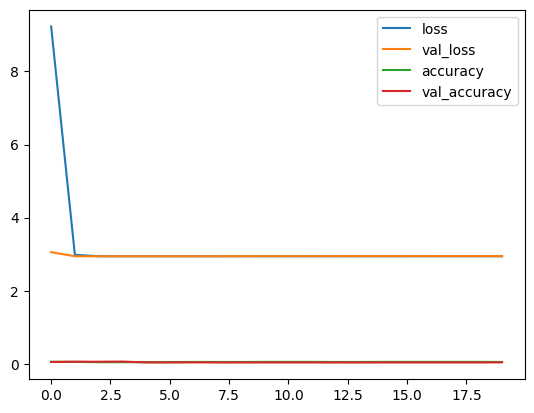

72/72 [==============================] - 8s 104ms/step - loss: 2.9441 - accuracy: 0.0537 - val_loss: 2.9480 - val_accuracy: 0.0421


In [6]:
# Erstes simples FFNN mit nur einer Hidden-Schicht

ffnn_1 = Sequential()

ffnn_1.add(Flatten())
ffnn_1.add(Dense(256, activation='relu'))
ffnn_1.add(Dense(19, activation='softmax'))

myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

ffnn_1.compile(loss='categorical_crossentropy',
            optimizer=myAdam, 
            metrics=['accuracy'])

#Modell trainieren
history_ffnn_1=ffnn_1.fit(X_train, y_train, 
          validation_data=(X_test, y_test),                              
          epochs=20,
          batch_size=64,
          verbose=1,
          callbacks=[plot_losses])

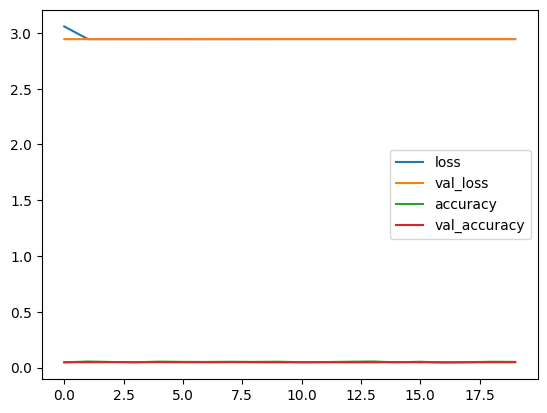

72/72 [==============================] - 1s 19ms/step - loss: 2.9445 - accuracy: 0.0504 - val_loss: 2.9460 - val_accuracy: 0.0474


In [7]:
# Erhöhte Komplexität mit 3 Hidden-Schichten, dafür weniger Neuronen pro Schicht

ffnn_2 = Sequential()

ffnn_2.add(Flatten())
ffnn_2.add(Dense(32, activation='relu'))
ffnn_2.add(Dense(32, activation='relu'))
ffnn_2.add(Dense(32, activation='relu'))
ffnn_2.add(Dense(19, activation='softmax'))

myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

ffnn_2.compile(loss='categorical_crossentropy',
            optimizer=myAdam, 
            metrics=['accuracy'])

#Modell trainieren
history_ffnn_2=ffnn_2.fit(X_train, y_train, 
          validation_data=(X_test, y_test),                              
          epochs=20,
          batch_size=64,
          verbose=1,
          callbacks=[plot_losses])

Sehr schlechte Ergebnisse, da die hohe Anzahl der Features (256*128) durch solch kleine FFNN nicht richtig verarbeitet werden kann und auch da räumliche Zusammenhänge aufgrund des Flattens verloren gehen

In [9]:
# Ganz einfaches CNN mit nur 2-Conv2D Layer

cnn_1 = Sequential()

cnn_1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 128, 1)))
cnn_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_1.add(MaxPooling2D(pool_size=(2, 2)))

cnn_1.add(Flatten())
cnn_1.add(Dense(128, activation='relu'))
cnn_1.add(Dense(19, activation='softmax'))

myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Kompilieren des Modells
cnn_1.compile(loss='categorical_crossentropy',
            optimizer=myAdam, 
            metrics=['accuracy'])

#Modell trainieren
history_cnn_1=cnn_1.fit(X_train, y_train, 
          validation_data=(X_test, y_test),                              
          epochs=20,
          batch_size=64,
          verbose=1,
          callbacks=[plot_losses])

2024-01-15 15:11:25.634456: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255983616 exceeds 10% of free system memory.
2024-01-15 15:11:25.759254: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255983616 exceeds 10% of free system memory.
2024-01-15 15:11:25.800612: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255983616 exceeds 10% of free system memory.
2024-01-15 15:11:27.247757: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 597688320 exceeds 10% of free system memory.


Epoch 1/20


2024-01-15 15:11:27.944000: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255983616 exceeds 10% of free system memory.


: 

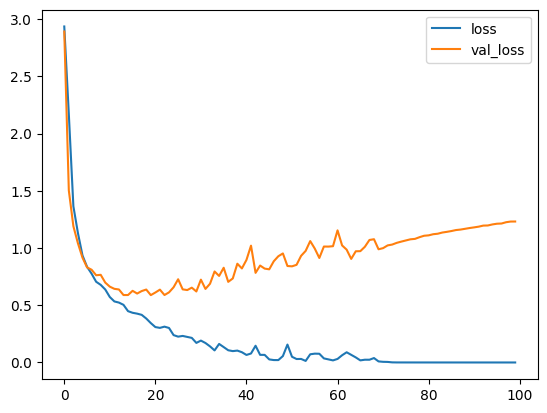

72/72 [==============================] - 32s 450ms/step - loss: 5.8655e-05 - accuracy: 1.0000 - val_loss: 1.2315 - val_accuracy: 0.8430


: 

In [14]:
cnn_2 = Sequential()

cnn_2.add(Conv2D(16, (3,3), activation='relu', input_shape=(256, 128, 1)))
cnn_2.add(MaxPooling2D(2, 2))

cnn_2.add(Conv2D(32, (3,3), activation='relu'))
cnn_2.add(MaxPooling2D(2, 2))

cnn_2.add(Conv2D(64, (3,3), activation='relu'))
cnn_2.add(MaxPooling2D(2, 2))

cnn_2.add(Conv2D(64, (3,3), activation='relu'))
cnn_2.add(MaxPooling2D(2, 2))

cnn_2.add(Conv2D(64, (3,3), activation='relu'))
cnn_2.add(MaxPooling2D(2, 2))

cnn_2.add(Flatten())
cnn_2.add(Dense(512, activation='relu'))
cnn_2.add(Dense(19, activation='softmax'))

myAdam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

cnn_2.compile(loss='categorical_crossentropy',
            optimizer=myAdam, 
            metrics=['accuracy'])

history_cnn_2=cnn_2.fit(X_train, y_train, 
          validation_data=(X_test, y_test),                              
          epochs=100,
          batch_size=64,
          verbose=1,
          callbacks=[plot_losses])

Die CNNs (besonders das Zweite) liefern gute Ergebnisse. Aufgrund eingeschränkter Möglichkeiten wurde nur mit einer begrenzten Anzahl an Bildern pro Klasse trainiert. Bei Verwendung aller Bilder und längerem Training sind noch bessere Ergebnisse zu erwarten. Eine weitere Verbesserung könnte durch die Verwendung sehr großer vortrainierter CNNs wie ResNET erzielt werden. Dieses müsste dann noch auf unsere speziellen Daten nachtrainiert werden.